In [24]:
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1 K-Means

## Custom KMeans Implementation

In [32]:
class customKMeans:
    def __init__(self, K, max_iters=100, epsilon=1e-4, random_state=0):
        self.K = K  
        self.epsilon = epsilon  
        self.max_iters = max_iters  
        self.random_state = random_state
        self.centroids = None
        self.clusters = None

    def _initialize_centroids(self, X):
        np.random.seed(self.random_state)
        centroids = [X[np.random.randint(X.shape[0])]]
        
        for _ in range(1, self.K):
            distances = np.min([np.linalg.norm(X - centroid, axis=1) for centroid in centroids], axis=0)
            probabilities = distances**2 / np.sum(distances**2)
            new_centroid = X[np.random.choice(X.shape[0], p=probabilities)]
            centroids.append(new_centroid)
        
        return np.array(centroids)
        
    def _assign_clusters(self, X, centroids):
        clusters = [] 
        for x in X: 
            distances = np.linalg.norm(x - centroids, axis=1)
            cluster = np.argmin(distances)
            clusters.append(cluster)
        return np.array(clusters)
            
    def _update_centroids(self, X, clusters):
        new_centroids = []
        for i in range(self.K): 
            cluster_points = X[clusters == i]
            new_centroid = cluster_points.mean(axis=0) if len(cluster_points) > 0 else self.centroids[i]
            new_centroids.append(new_centroid)
        return np.array(new_centroids)

    def fit(self, X):
        self.centroids = self._initialize_centroids(X)
        
        for _ in range(self.max_iters):
            self.clusters = self._assign_clusters(X, self.centroids)
            
            new_centroids = self._update_centroids(X, self.clusters)
            
            centroid_shift = np.linalg.norm(new_centroids - self.centroids, axis=1)
            if np.all(centroid_shift < self.epsilon):
                break
            
            self.centroids = new_centroids
        
        return self.centroids, self.clusters


## Optimized Custom KMeans Implementation

We want to optimize our custom KMeans class. We can do so by taking advantage of numpy's vectorized operations which are far more efficient than python loops.

The optimized class is as following:

In [26]:
class OptimizedCustomKMeans:
    def __init__(self, K, max_iters=100, epsilon=1e-4, random_state = 0):
        self.K = K  
        self.epsilon = epsilon  
        self.max_iters = max_iters  
        self.random_state = random_state
        self.centroids = None
        self.clusters = None


    def _intialize_centroids(self, X):
        np.random.seed(self.random_state)
        random_indices = np.random.permutation(X.shape[0])
        centroids = X[random_indices[:self.K]]
        return centroids
        

    def _assign_clusters(self, X, centroids):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, clusters):
        new_centroids = np.array([
            X[clusters == i].mean(axis=0) if np.any(clusters == i) else np.zeros(X.shape[1])
            for i in range(self.K)
        ])
        return new_centroids

    def fit(self, X):
        self.centroids = self._intialize_centroids(X)
        
        for i in range(self.max_iters):
            self.clusters = self._assign_clusters(X, self.centroids)
            
            new_centroids = self._update_centroids(X, self.clusters)
            
            centroid_shift = np.abs(new_centroids - self.centroids)
            if np.all(centroid_shift < self.epsilon):
                break
            
            self.centroids = new_centroids
        
        return self.centroids, self.clusters



## PCA Implementation using numpy.linalg.svd

In [27]:
def pca(X, n_components):

    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

    V = Vt.T[:, :n_components]
    X_pca = np.dot(X_centered, V)

    total_variance = np.sum(S ** 2)
    explained_variance_ratio = (S[:n_components] ** 2) / total_variance

    return X_pca, explained_variance_ratio

## Reading and Normalizing the Data

In [28]:
df = pd.read_csv('HTRU_2.csv')

unnorm_X = df.values

scaler = StandardScaler()
X = scaler.fit_transform(unnorm_X)

## Comparisons between the custom KMeans and the scikit KMeans and the optimized custom KMeans

6.634303331375122
[[ 0.18046533  0.06777447 -0.22050246 -0.21130129 -0.2904185  -0.23155302
  -0.06648208 -0.22722428]
 [ 0.09891407 -0.03989483 -0.20879925 -0.20331739 -0.38681085 -0.73915583
   1.479008    1.63740753]
 [ 0.20538414  0.76208886 -0.13882937 -0.19139089  2.3314015   2.49772091
  -1.7105867  -0.98082266]
 [-2.9042245  -1.78718041  3.67372009  3.61085909  1.73905853  1.87648055
  -1.49561442 -0.94552179]]


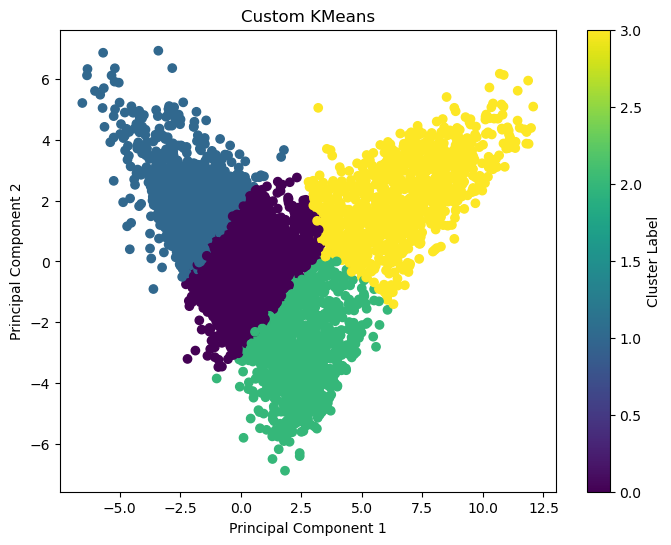

In [29]:
startcustom = time.time()
ckmeans = customKMeans(K=4, random_state = 0)  
ckmeans.fit(X)
endcustom = time.time()
print(endcustom - startcustom)

ccentroids, cclusters = ckmeans.centroids, ckmeans.clusters

print(ccentroids)

cX_pca, explained_variance_ratio = pca(X, n_components=2)

plt.figure(figsize=(8, 6))
plt.scatter(cX_pca[:, 0], cX_pca[:, 1], c=cclusters, cmap='viridis', marker='o')
plt.title('Custom KMeans')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

0.10469627380371094
[[ 0.18146861  0.06889671 -0.22062014 -0.21137341 -0.28936164 -0.22676983
  -0.07568053 -0.23592428]
 [-2.9042245  -1.78718041  3.67372009  3.61085909  1.73905853  1.87648055
  -1.49561442 -0.94552179]
 [ 0.20615098  0.76362586 -0.13864939 -0.19115886  2.33748858  2.5005479
  -1.71187343 -0.9809531 ]
 [ 0.09807158 -0.03963067 -0.20879348 -0.20343424 -0.38624682 -0.73481251
   1.45048099  1.59474885]]


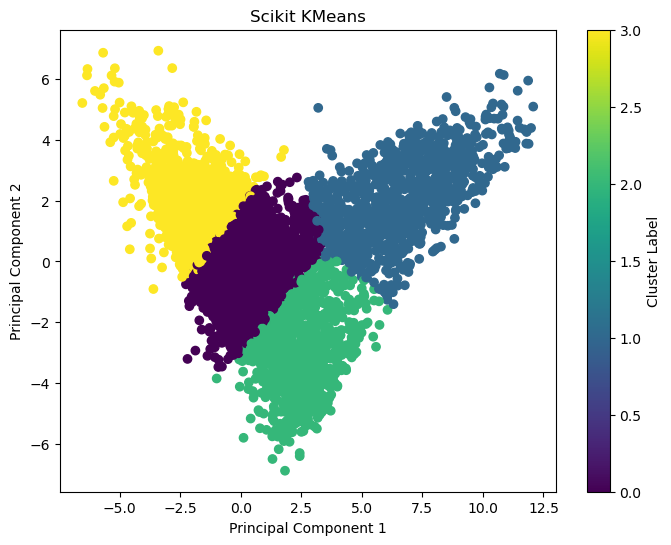

In [30]:
startscikit = time.time()
kmeans = KMeans(n_clusters=4, random_state=0) 
kmeans.fit(X)
endscikit = time.time()

print(endscikit - startscikit)

centroids = kmeans.cluster_centers_
clusters = kmeans.labels_

print(centroids)

X_pca, explained_variance_ratio = pca(X, n_components=2)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('Scikit KMeans')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

0.11855006217956543
[[ 0.18046533  0.06777447 -0.22050246 -0.21130129 -0.2904185  -0.23155302
  -0.06648208 -0.22722428]
 [ 0.09891407 -0.03989483 -0.20879925 -0.20331739 -0.38681085 -0.73915583
   1.479008    1.63740753]
 [ 0.20538414  0.76208886 -0.13882937 -0.19139089  2.3314015   2.49772091
  -1.7105867  -0.98082266]
 [-2.9042245  -1.78718041  3.67372009  3.61085909  1.73905853  1.87648055
  -1.49561442 -0.94552179]]


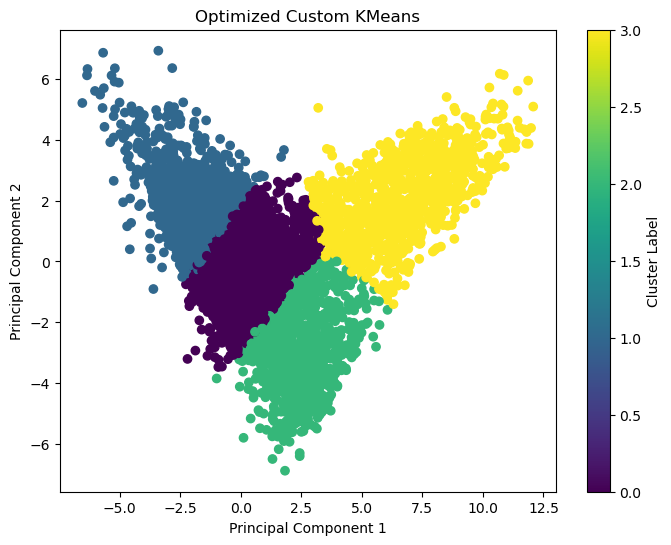

In [31]:
startoptcustom = time.time()
ockmeans = OptimizedCustomKMeans(K=4)  
ockmeans.fit(X)
endoptcustom = time.time()
print(endoptcustom - startoptcustom)

occentroids, occlusters = ckmeans.centroids, ckmeans.clusters

print(occentroids)

ocX_pca, explained_variance_ratio = pca(X, n_components=2)

plt.figure(figsize=(8, 6))
plt.scatter(ocX_pca[:, 0], ocX_pca[:, 1], c=occlusters, cmap='viridis', marker='o')
plt.title('Optimized Custom KMeans')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

## Elbow plots for different random intializations

In [128]:
def plot_elbow(X, max_k=10, max_iters=100, epsilon=1e-4, random_state=0):
    inertias = []
    
    for k in range(1, max_k + 1):
        kmeans = OptimizedCustomKMeans(K=k, max_iters=max_iters, epsilon=epsilon, random_state=random_state)
        centroids, clusters = kmeans.fit(X)
        
        inertia = np.sum(np.linalg.norm(X - centroids[clusters], axis=1)**2)
        inertias.append(inertia)

    plt.plot(range(1, max_k + 1), inertias, marker='o')
    plt.title(f'Elbow with random state {random_state}')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.show()


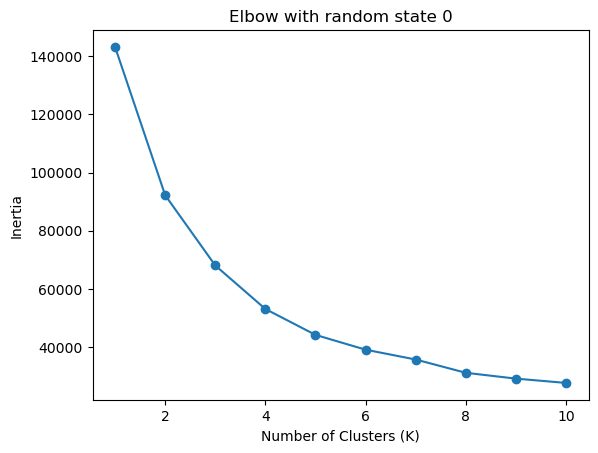

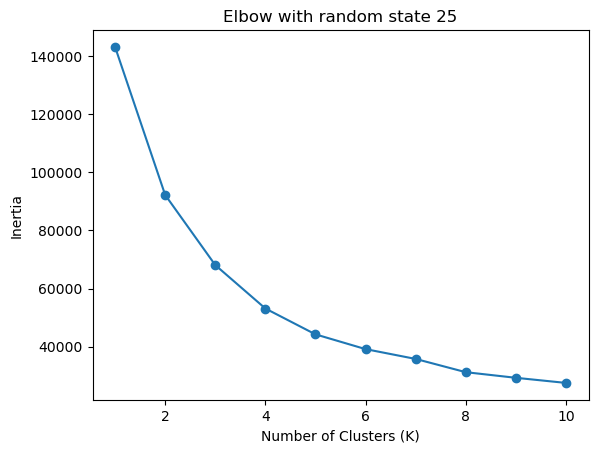

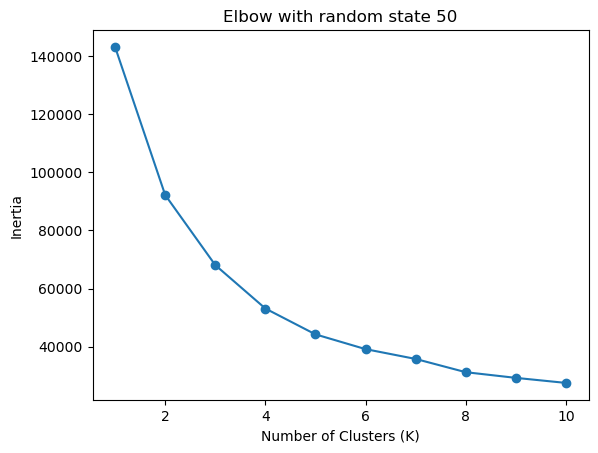

In [129]:
plot_elbow(X, random_state = 0)
plot_elbow(X, random_state = 25)
plot_elbow(X, random_state = 50)